Many models can be used to make predictions instead of one "golden" or "magic" model. This notebook includes code for multiple models--each with different strengths and weaknesses:

*   **Simple Moving Average**
    *   What an SMA tells you: trends but does not predict future prices
    *   Strength: This confirms past trends.
    *   Weakness: Does not predict future. Sensitive to the time you average over.
    *   Possible improvements:

*   **Insider Trading**
    *   What an IT tells you: We assume insiders buy and sell to make profits, they have within 6 month vision of whether the company's stock will go up or down, and they are ok with breaking insider trading laws
    *   Strength: Probably more insightful then media news since insiders know more
    *   Weakness: Strong insider trading is useful; low or weak trading doesn't tell us anything. Insiders may sell or buy to help keep stock price stable
    *   Possible improvements:
    
*   **Linear Fit On Price**
    *   What an LFP tells you: linear trends over long term but does not predict future prices
    *   Strength: Many larger companies with less volitate stock prices seems to fit to lines quite well. This confirms past trends.
    *   Weakness:
    *   Possible improvements:
    
*   **Volatility Measure**
    *   What an VM tells you: has to stock price been volitate recently. We assume it will continue in the trend though it does not explicity predict that
    *   Strength: measures volatility. This could be a good measure to weight all other models by. High volatility would mean the price will change soon and thus, look at your other models to see if that change will be up or down.
    *   Weakness: Does not predict future.
    *   Possible improvements:

*   **Twitter Sentiment**
    *   What an TS tells you: what does the news say about the stock
    *   Strength: 
    *   Weakness: could be missing keywords, or interpreting keywords incorrectly due to some context like "not good."
    *   Possible improvements: include other social media platforms



In [1]:
#packages needed for all models
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt

#Interactive plotting library
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
#replaces spaces in column names with '_'
#turns dates into datetime objects
#sets Date to index
def format_df(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    df['Date']=pd.to_datetime(df['Date'])
    df = df.set_index(df['Date'], drop=True) #index by date
    return df

**The Simple Moving Average**
What to look for:
*    200 day window.
*    52 day window.
*    If long window dips below short probably buy
*    If long window and short window gap widens probably hold

Notes:

In [3]:
ticker = 'APPL'

#import daily data from file
df = pd.read_csv("../Data/Data/AAPL.csv",index_col=[0])

# Format Df
df = format_df(df)

df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,,
2009-08-05,2009-08-05,23.678572,23.912857,23.458570,23.587143,20.663019,105795900
2009-08-06,2009-08-06,23.654285,23.787144,23.298571,23.415714,20.512846,85404200
2009-08-07,2009-08-07,23.641428,23.799999,23.542856,23.644285,20.713081,96838700
2009-08-10,2009-08-10,23.665714,23.799999,23.379999,23.531429,20.614218,75073600
2009-08-11,2009-08-11,23.384285,23.482857,23.125713,23.261429,20.377687,88835600


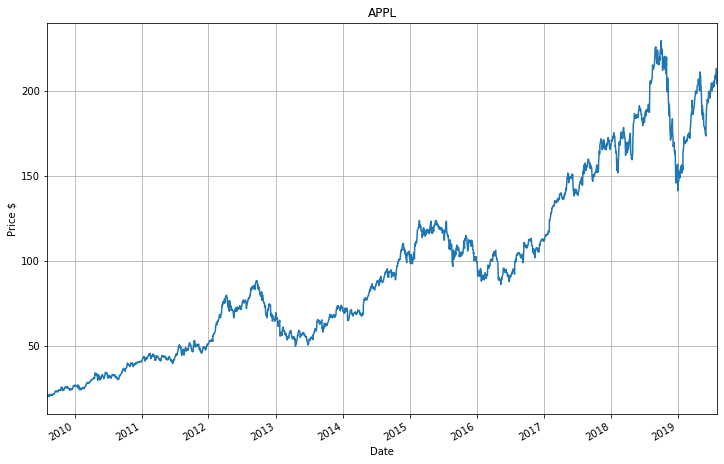

In [4]:
# Plot the closing prices

df['Adj_Close'].plot(grid=True,figsize=(12,8))
plt.title(ticker)
plt.ylabel('Price $')

# Show all of the data
plt.show()

#Interactive plotting style
#p = figure(title=ticker,x_axis_label='Date',y_axis_label='Price $', plot_width=800, plot_height=500)
#p.line(df.Date, df.Adj_Close, line_width=2)
#show(p)

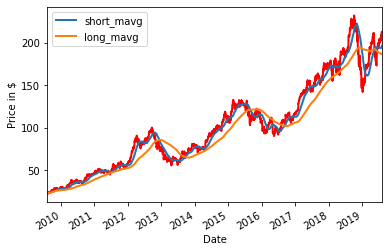

In [5]:
#Calculate and Plot SMA
# Initialize the short and long windows
short_window = 52
long_window = 200

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Plot
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')

df['Close'].plot(ax=ax1, color='r', lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
#ax1.plot(signals.loc[signals.positions == 1.0].index,
#         signals.loc[signals.positions == 1.0],
#         "^", markersize=10, color="c")
         
# Plot the sell signals
#ax1.plot(signals.loc[signals.positions == -1.0].index,
#         signals.loc[signals.positions == -1.0],
#         "v", markersize=10, color="k")
         
plt.show()

In [6]:
# Bohek plot (interactie)
p = figure(title=ticker, x_axis_type='datetime', y_axis_label='Price $', plot_width=700)
p.line(df.index.values, df['Close'], color='red', legend='Close')
p.line(df.index.values, signals['short_mavg'], color='green', legend='short mavg')
p.line(df.Date.values, signals['long_mavg'], color='blue', legend='long mavg')

p.legend.click_policy="hide"
p.legend.location = 'top_left'

##need to figure out how to add the buy and sell signals
p.circle(signals.loc[signals.positions == 1.0].index,
         signals.loc[signals.positions == 1.0].short_mavg,size=15, color="green", alpha=0.9)
p.circle(signals.loc[signals.positions == -1.0].index,
         signals.loc[signals.positions == -1.0].short_mavg,size=15, color="red", alpha=0.9)
show(p)

In [7]:
signals.loc[signals.positions == 1.0].index

DatetimeIndex(['2009-10-19', '2013-09-13', '2016-09-06', '2019-05-09'], dtype='datetime64[ns]', name='Date', freq=None)

**Volatility Measure**
What to look for:
*    Comparison between ticker and DJI or other ticker.

Notes: For Microsoft, F-distribution better fits ratio of volatility than normal distribution fits difference in volatility over last three years

In [8]:
#Upload DJI average from drive csv file. DJI data is used as a standard volatility measure to compare to your ticker of interest

#3. Read file as panda dataframe
df_dow = pd.read_csv('../Data/Data/^DJI.csv',index_col=[0])

#format df
df_dow = format_df(df_dow)

df_dow.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,,
2009-08-06,2009-08-06,9277.190430,9325.110352,9208.799805,9256.259766,9256.259766,244450000
2009-08-07,2009-08-07,9258.450195,9437.709961,9258.450195,9370.070313,9370.070313,216600000
2009-08-10,2009-08-10,9368.410156,9371.959961,9290.339844,9337.950195,9337.950195,161370000
2009-08-11,2009-08-11,9334.330078,9334.330078,9216.879883,9241.450195,9241.450195,171380000
2009-08-12,2009-08-12,9236.059570,9424.110352,9221.019531,9361.610352,9361.610352,197420000


In [9]:
df_dow.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,,
2019-07-29,2019-07-29,27192.240234,27275.849609,27178.060547,27221.349609,27221.349609,250850000
2019-07-30,2019-07-30,27145.390625,27224.359375,27069.859375,27198.019531,27198.019531,293250000
2019-07-31,2019-07-31,27244.669922,27281.650391,26719.599609,26864.269531,26864.269531,385150000
2019-08-01,2019-08-01,26879.859375,27175.589844,26548.710938,26583.419922,26583.419922,386320000
2019-08-02,2019-08-02,26528.660156,26570.019531,26249.220703,26485.009766,26485.009766,327640000


In [10]:
#Calculate volitity NEEDS TO BE COMPARED TO SOMETHING (PROBABLY DOW AVERAGE)

daily_close_px_dow = df_dow[['Adj_Close']]
daily_close_px = df[['Adj_Close']]

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change_dow = daily_close_px_dow.pct_change()
daily_pct_change = daily_close_px.pct_change()

# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol_dow = daily_pct_change_dow.rolling(min_periods).std() * np.sqrt(min_periods)
vol_ticker = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

In [11]:
# Bohek plot (interactie)
p = figure(title=ticker+' volatility comparison',x_axis_type='datetime',y_axis_label='% Change of Adj Close')
p.line(vol_ticker.index.values,vol_ticker['Adj_Close'],color = 'blue',legend=ticker+' volatility')
p.line(vol_dow.index.values,vol_dow['Adj_Close'],color = 'red',legend='DJI volatility')

p.legend.click_policy="hide"
show(p)

In [12]:
#Calculate and plot to difference between DJI volatility and ticker
vol_diff = vol_ticker.join(vol_dow, how='inner', lsuffix='_tick', rsuffix='_dow') #join dow and ticker only inlcuding ticker dates
vol_diff.head()
vol_diff['Dif'] = vol_diff['Adj_Close_tick'] - vol_diff['Adj_Close_dow']
vol_diff['Ratio'] = vol_diff['Adj_Close_tick']/vol_diff['Adj_Close_dow']

vol_diff = vol_diff.dropna()
vol_diff.head()

,Adj_Close_tick,Adj_Close_dow,Dif,Ratio
Date,,,,
2009-11-20,0.138858,0.083035,0.055823,1.672284
2009-11-23,0.141306,0.083112,0.058193,1.700176
2009-11-24,0.141448,0.083024,0.058423,1.703686
2009-11-25,0.140753,0.082159,0.058594,1.713173
2009-11-27,0.141728,0.082976,0.058751,1.708047


count    2440.000000
mean        0.064779
std         0.026882
min         0.008905
25%         0.047148
50%         0.062459
75%         0.075386
max         0.166972
Name: Dif, dtype: float64

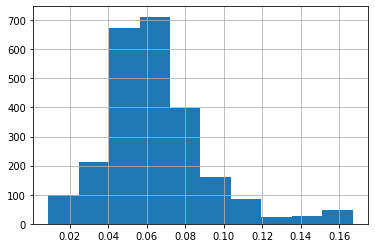

In [13]:
# Bohek plot (interactie)
p = figure(title=ticker+' volatility comparison',x_axis_type='datetime',y_axis_label='Volatility')
p.line(vol_diff.index.values,vol_diff['Dif'],color = 'blue',legend='Volatility Difference')

p.legend.click_policy="hide"
show(p)

vol_diff['Dif'].hist()

vol_diff['Dif'].describe()

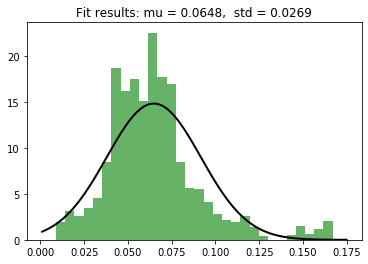

In [14]:
#Fit histogram to normal distribution?
data = vol_diff['Dif'].dropna()

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.4f,  std = %.4f" % (mu, std)
plt.title(title)

plt.show()

Loading BokehJS ...

count    2440.000000
mean        2.033822
std         0.556546
min         1.056797
25%         1.679139
50%         1.925224
75%         2.268877
max         4.187542
Name: Ratio, dtype: float64

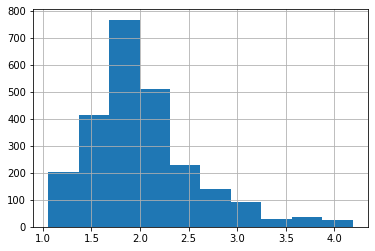

In [15]:
# Bohek plot (interactie)
output_notebook()
p = figure(title=ticker+' volatility comparison',x_axis_type='datetime',y_axis_label='Volatility $')
p.line(vol_diff.index.values,vol_diff['Ratio'],color = 'blue',legend='Volatility Ratio')

p.legend.click_policy="hide"
show(p)

vol_diff['Ratio'].hist()

vol_diff['Ratio'].describe()

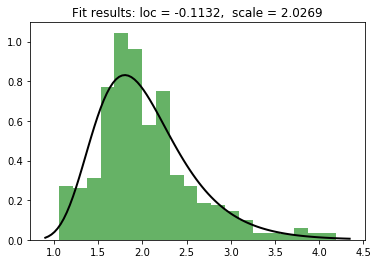

In [16]:
#Fit histogram to f-distribution?
data = vol_diff['Ratio'].dropna()

# Fit a normal distribution to the data:
df1, df2, loc, scale = stats.f.fit(data, 2, 1, loc=0, scale=1)

# Plot the histogram.
plt.hist(data, bins=20, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.f.pdf(x, df1, df2,loc,scale)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: loc = %.4f,  scale = %.4f" % (loc, scale)
plt.title(title)

plt.show()

**Insider Trades**
What to look for:
*    More selling then buying?
*    Particular insider buy a lot/selling a lot
*    Insiders probably have <6 month view (according to *The Trival Many Vs. the Vital Few*)

Notes:

In [0]:
#Go to this website
url = 'https://finance.yahoo.com/quote/'+ticker+'/insider-transactions?p='+ticker
print(url)

https://finance.yahoo.com/quote/MSFT/insider-transactions?p=MSFT
